# IMPORT MODULES

In [1]:
import numpy as np
np.random.seed(13)
import torch
torch.manual_seed(21)
import matplotlib.pyplot as plt
import warnings
from mlcvs.utils.data import create_time_lagged_dataset, FastTensorDataLoader
from torch.utils.data import Subset,random_split
from mlcvs.utils.io import load_dataframe
warnings.filterwarnings('ignore')
from mlcvs.tica import DeepTICA_CV

import pandas

### time lagged dataset 

In [2]:
from bisect import bisect_left

def closest_idx_torch(array, value):
        '''
        Find index of the element of 'array' which is closest to 'value'.
        The array is first converted to a np.array in case of a tensor.
        Note: it does always round to the lowest one.

        Parameters:
            array (tensor/np.array)
            value (float)

        Returns:
            pos (int): index of the closest value in array
        '''
        if type(array) is np.ndarray:
            pos = bisect_left(array, value)
        else:
            pos = bisect_left(array.numpy(), value)
        if pos == 0:
            return 0
        elif pos == len(array):
            return -1
        else:
            return pos-1

def find_time_lagged_configurations(x,t,lag):
    '''
    Searches for all the pairs which are distant 'lag' in time, and returns the weights associated to lag=lag as well as the weights for lag=0.

    Parameters:
        x (tensor): array whose columns are the descriptors and rows the time evolution
        time (tensor): array with the simulation time
        lag (float): lag-time

    Returns:
        x_t (tensor): array of descriptors at time t
        x_lag (tensor): array of descriptors at time t+lag
        w_t (tensor): weights at time t
        w_lag (tensor): weights at time t+lag
    '''
    #define lists
    x_t = []
    x_lag = []
    w_t = []
    w_lag = []
    #find maximum time idx
    idx_end = closest_idx_torch(t,t[-1]-lag)
    #print(idx_end)
    #start_j = 0
    
    #loop over time array and find pairs which are far away by lag
    for i in range(idx_end):
        stop_condition = lag+t[i+1]
        n_j = 0
        for j in range(i,len(t)):
            if ( t[j] < stop_condition ) and (t[j+1]>t[i]+lag):
                x_t.append(x[i])
                x_lag.append(x[j])
                deltaTau=min(t[i+1]+lag,t[j+1]) - max(t[i]+lag,t[j])
                w_lag.append(deltaTau)
                #if n_j == 0: #assign j as the starting point for the next loop
                #    start_j = j
                n_j +=1
            elif t[j] > stop_condition:
                break
        for k in range(n_j):
            w_t.append((t[i+1]-t[i])/float(n_j))

    x_t = torch.stack(x_t) if type(x) == torch.Tensor else torch.Tensor(x_t)
    x_lag = torch.stack(x_lag) if type(x) == torch.Tensor else torch.Tensor(x_lag)
    
    w_t = torch.Tensor(w_t)
    w_lag = torch.Tensor(w_lag)

    return x_t,x_lag,w_t,w_lag

def create_time_lagged_dataset(X, t = None, lag_time = 10, logweights = None):
    """
    Create a dataset of time-lagged configurations. If a set of (log)weights is given the search is performed in the accelerated time.

    Parameters
    ----------
    X : array-like
        input descriptors
    t : array-like, optional
        time series, by default np.arange(len(X))
    lag_time: float, optional
        lag between configurations, by default = 10        
    logweights : array-like,optional
        logweights to evaluate rescaled time as dt' = dt*exp(logweights)
    """

    # check if dataframe
    if type(X) == pandas.core.frame.DataFrame:
        X = X.values
    if type(t) == pandas.core.frame.DataFrame:
        t = t.values

    # assert
    assert t.ndim == 1 
    assert len(X) == len(t)

    # define time if not given
    if t is None:
        t = np.arange(0,len(X))

    # rescale time with log-weights if given
    if logweights is not None:
        # assert 
        assert logweights.ndim == 1
        assert len(X) == len(logweights)
        # compute time increment in simulation time t
        dt = np.round(t[1]-t[0],3)
        # sanitize logweights
        logweights = torch.Tensor(logweights)
        logweights -= torch.max(logweights)
        lognorm = torch.logsumexp(logweights,0)
        logweights /= lognorm
        # compute instantaneus time increment in rescaled time t'
        d_tprime = torch.exp(logweights)*dt
        # calculate cumulative time t'
        tprime = torch.cumsum(d_tprime,0)
    else:
        tprime = t

    # find pairs of configurations separated by lag_time
    data = find_time_lagged_configurations(X, tprime,lag=lag_time)

    #return data
    return torch.utils.data.TensorDataset(*data)


### plot functions

In [3]:
#-- plot model loss function --#
def plot_model_lossfunction(model):

    n_eig=len(model.nn[-1].bias)

    fig, axs = plt.subplots(1,2,figsize=(12,5))#,dpi=100)

    loss_train = [x.cpu() for x in model.loss_train]
    loss_valid = [x.cpu() for x in model.loss_valid]

    # Loss function
    ax = axs[0]
    ax.plot(loss_train,'-',label='Train')
    ax.plot(loss_valid,'--',label='Valid')
    ax.set_ylabel('Loss Function')

    # Eigenvalues vs epoch
    ax = axs[1]
    with torch.no_grad():
        evals_train = np.asarray(torch.cat(model.evals_train).cpu())
    for i in range(n_eig):
        ax.plot(evals_train[:,i],label='Eig. '+str(i+1))
    ax.set_ylabel('Eigenvalues')
    
    # Common setup
    for ax in axs:
        if model.earlystopping_.best_epoch is not None:
            if model.earlystopping_.early_stop:
                ax.axvline(model.earlystopping_.best_epoch,ls='dotted',color='grey',alpha=0.5,label='Early Stopping')
                ax.set_xlabel('#Epochs')
                ax.legend(ncol=2)

    plt.tight_layout()

def plot_cvs_isolines(model,limits=((-3,3),(-3,3)),points=150,n_out=2,scatter=None,axs=None):

    #-- prepare grid --#
    xx,yy = np.meshgrid(np.linspace(limits[0][0],limits[0][1],points),np.linspace(limits[1][0],limits[1][1],points))
    grid = np.transpose(np.array([xx.reshape(points*points),yy.reshape(points*points)]))

    #-- evaluate cvs on the grid --#
    cvs = []
    for i in range(n_out):
        cvs.append(np.transpose(model(torch.Tensor(grid)).detach().cpu().numpy())[i].reshape(points,points))

    #-- plotting --#
    if axs is None:
        fig,axs = plt.subplots(1,n_out,figsize=(12,6))

    for k,ax in enumerate(axs):
        cset = ax.contourf(xx,yy,cvs[k],linewidths=1,cmap="fessa")
        cset = ax.contour(xx,yy,cvs[k],linewidths=3,cmap="gray",linestyles="dashed")
        ax.clabel(cset,inline=True,fmt='%1.1f',fontsize=15)
        ax.set_xlabel("p.x")
        ax.set_ylabel("p.y")
        ax.set_title('Deep-TICA '+str(k+1))
        if scatter is not None:
            ax.scatter(scatter[:,0],scatter[:,1],s=2,c='white',alpha=0.8)
            ax.set_aspect('equal')
        
    plt.tight_layout()
    plt.show()

<AxesSubplot:xlabel='p.x', ylabel='p.y'>

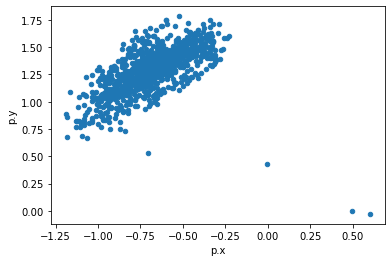

In [4]:
#-- short_COLVAR 1 MB, same results --#
#-- COLVAR: 51 MB --#
path = "short_COLVAR_pandas"
data = load_dataframe(path)
data.plot.scatter(x="p.x",y="p.y")

In [5]:
%%time
temp = 0.5
lag_time = 10
X, t, logweights = data.filter(regex="^p.").values, data['time'].values, (data["opes.bias"].to_numpy()-max(data["opes.bias"].to_numpy()) ) / temp

dataset = create_time_lagged_dataset(X,t=t,lag_time=lag_time,logweights=logweights)

x_t,x_lag,w_t,w_lag = dataset[:][0],dataset[:][1],dataset[:][2],dataset[:][3] 

CPU times: user 691 ms, sys: 4.1 ms, total: 696 ms
Wall time: 695 ms


In [6]:
#-- to run process from jupyter --#
import subprocess
import os
from pathlib import Path
# execute bash command in the given folder
def execute(command, folder, background=False, print_result=True):
    cmd = subprocess.run(command, cwd=folder, shell=True, capture_output = True, text=True, close_fds=background)
    if cmd.returncode == 0:
        if print_result:
            print(f'Completed: {command}')
    else:
        print(cmd.stderr)

In [7]:
%%time
#-- compile cpp, longest procedure --#
execute("make",folder=".")
#-- remove old files
execute("rm w_lag.txt w_t.txt x_lag.txt x_t.txt",folder=".", print_result=False)

#-- write input file to create time lagged dataset --#
names = load_dataframe(path).filter(regex="^p.").columns
first_index = data.columns.get_loc(names[0])
last_index = data.columns.get_loc(names[-1])
weights_index = data.columns.get_loc("opes.bias")
# colvar = <COLVAR filename>
# temp = <temperature>
# lag = <lag time>
# first_index = <first index column of the descriptors in COLVAR>
# last_index = <last index column of the descriptors in COLVAR>
# if_weights = <0 or 1, in order to use or not the rescaled time>
# weights_index = <column index in COLVAR for logweights >
with open("input.dat","w") as file:
    print("""colvar = """+path+"""
temp = """+str(temp)+"""
lag = """+str(lag_time)+"""
first_index = """+str(first_index)+"""
last_index = """+str(last_index)+"""
if_weights = 1
weights_index = """+str(weights_index)+"""
""",file=file)
!cat input.dat

Completed: make
colvar = short_COLVAR_pandas
temp = 0.5
lag = 10
first_index = 3
last_index = 4
if_weights = 1
weights_index = 6

CPU times: user 13.2 ms, sys: 31.6 ms, total: 44.8 ms
Wall time: 3.92 s


In [8]:
%%time
#-- run create_time_lagged_dataset.exe --#
execute("./create_time_lagged_dataset.exe input.dat",folder=".")

#--load data with pandas, much faster than numpy --#
cpp_xt = torch.Tensor(pandas.read_csv("x_t.txt",delimiter="\t",dtype=float,header=None).to_numpy())
cpp_xlag = torch.Tensor(pandas.read_csv("x_lag.txt",delimiter="\t",dtype=float,header=None).to_numpy())
cpp_wt = torch.Tensor( np.transpose( pandas.read_csv("w_t.txt",delimiter="\t",dtype=float,header=None).to_numpy() )[0] )
cpp_wlag = torch.Tensor( np.transpose( pandas.read_csv("w_lag.txt",delimiter="\t",dtype=float,header=None).to_numpy() )[0] )

#-- create TensorDataset for training --#
data = cpp_xt,cpp_xlag,cpp_wt,cpp_wlag
dataset_cpp = torch.utils.data.TensorDataset(*data)

Completed: ./create_time_lagged_dataset.exe input.dat
CPU times: user 12 ms, sys: 8 ms, total: 20 ms
Wall time: 39.7 ms


In [9]:
print(w_lag[:].shape)
print(cpp_wlag[:].shape)
print(w_lag[:])
print(cpp_wlag[:])

torch.Size([1886])
torch.Size([1886])
tensor([0.0135, 0.0135, 0.0135,  ..., 0.0742, 0.1854, 0.0449])
tensor([0.0135, 0.0135, 0.0135,  ..., 0.0742, 0.1854, 0.0449])


# Test Training
## python version

In [10]:
#-- TRAINING PARAMETERS --#
n_output = 2
n_input = 2
train_parameters = {
              'descriptors': '^p.',
              'nodes':[n_input,10,n_output], 
              'activ_type': 'tanh',
              'lag_time':2,
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.7,
              'lrate':1e-3,
              'l2_reg':0.,
              'num_epochs':1000,
              'earlystop':True,
              'es_patience':100,
              'es_consecutive':False,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':50,
              #if reweight the timescale
              "reweighting": True,
              }
#--------------------------------------#

In [11]:
torch.manual_seed(21)
n_train  = int( 0.7 * len(dataset) )
n_valid  = len(dataset) - n_train
train_data, valid_data = random_split(dataset,[n_train,n_valid])

# create dataloaders
train_loader = FastTensorDataLoader(train_data, batch_size=len(train_data))
valid_loader = FastTensorDataLoader(valid_data, batch_size=len(valid_data))

print('Time-lagged pairs:\t',len(dataset))
print('Training data:\t\t',len(train_data))
print('Validation data:\t',len(valid_data))

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL
model = DeepTICA_CV(train_parameters['nodes'],activation=train_parameters['activ_type'])
model.to(device)

# OPTIMIZER (Adam)
opt = torch.optim.Adam(model.parameters(), lr=train_parameters['lrate'], weight_decay=train_parameters['l2_reg'])

# REGULARIZATION
model.set_optimizer(opt)
model.set_earlystopping(patience=train_parameters['es_patience'],
                        min_delta=0.,consecutive=train_parameters['es_consecutive'], save_best_model=True, log=False)

# TRAIN
model.fit(train_loader,valid_loader,
    standardize_inputs=train_parameters['standardize_inputs'],
    standardize_outputs=train_parameters['standardize_outputs'],
    loss_type=train_parameters['loss_type'],
    n_eig=train_parameters['n_eig'],
    nepochs=train_parameters['num_epochs'],
    info=False, log_every=train_parameters['log_every'])

Time-lagged pairs:	 1886
Training data:		 1320
Validation data:	 566
Epoch Train Loss  Valid Loss  Eigenvalues             
50    0.002       -0.145      0.058  -0.061 
100   -0.057      -0.165      0.075  -0.042 
INFO: Early stopping
150   -0.081      -0.117      0.090  -0.042 


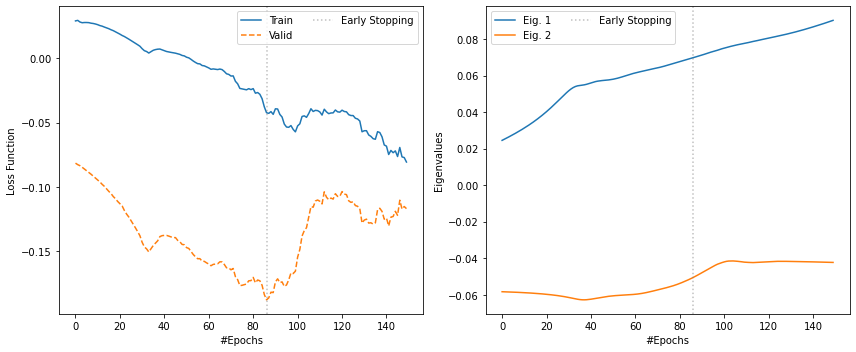

In [12]:
model.to("cpu")
plot_model_lossfunction(model)

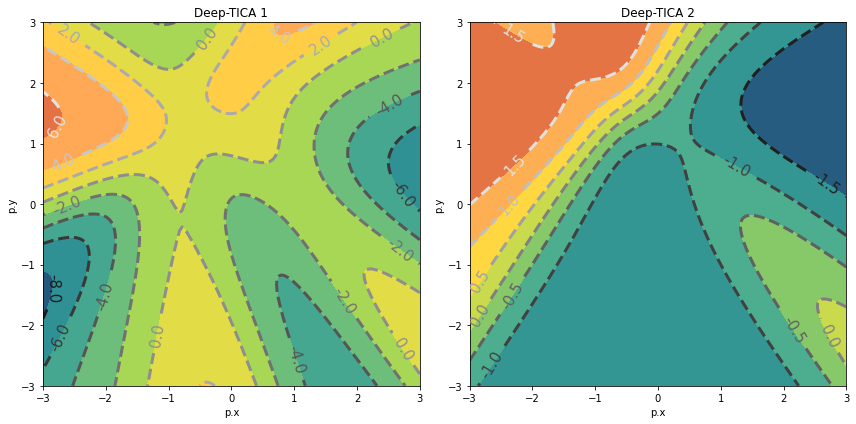

In [13]:
plot_cvs_isolines(model,points=150,n_out=2,scatter=None,axs=None)

## CPP Training

In [14]:
torch.manual_seed(21)
n_train  = int( 0.7 * len(dataset_cpp) )
n_valid  = len(dataset_cpp) - n_train
train_data, valid_data = random_split(dataset_cpp,[n_train,n_valid])

# create dataloaders
train_loader = FastTensorDataLoader(train_data, batch_size=len(train_data))
valid_loader = FastTensorDataLoader(valid_data, batch_size=len(valid_data))

print('Time-lagged pairs:\t',len(dataset_cpp))
print('Training data:\t\t',len(train_data))
print('Validation data:\t',len(valid_data))

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL
model_cpp = DeepTICA_CV(train_parameters['nodes'],activation=train_parameters['activ_type'])
model_cpp.to(device)

# OPTIMIZER (Adam)
opt = torch.optim.Adam(model_cpp.parameters(), lr=train_parameters['lrate'], weight_decay=train_parameters['l2_reg'])

# REGULARIZATION
model_cpp.set_optimizer(opt)
model_cpp.set_earlystopping(patience=train_parameters['es_patience'],
                        min_delta=0.,consecutive=train_parameters['es_consecutive'], save_best_model=True, log=False)

# TRAIN
model_cpp.fit(train_loader,valid_loader,
    standardize_inputs=train_parameters['standardize_inputs'],
    standardize_outputs=train_parameters['standardize_outputs'],
    loss_type=train_parameters['loss_type'],
    n_eig=train_parameters['n_eig'],
    nepochs=train_parameters['num_epochs'],
    info=False, log_every=train_parameters['log_every'])

Time-lagged pairs:	 1886
Training data:		 1320
Validation data:	 566
Epoch Train Loss  Valid Loss  Eigenvalues             
50    0.001       -0.146      0.058  -0.061 
100   -0.056      -0.164      0.075  -0.042 
150   -0.060      -0.090      0.090  -0.042 
INFO: Early stopping
157   -0.054      -0.061      0.093  -0.042 


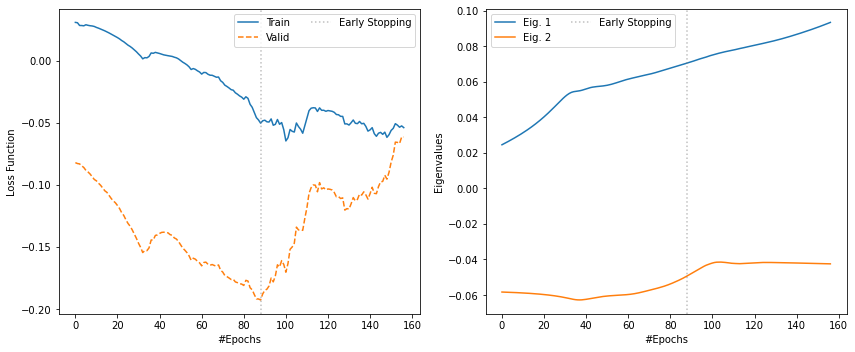

In [15]:
model_cpp.to("cpu")
plot_model_lossfunction(model_cpp)

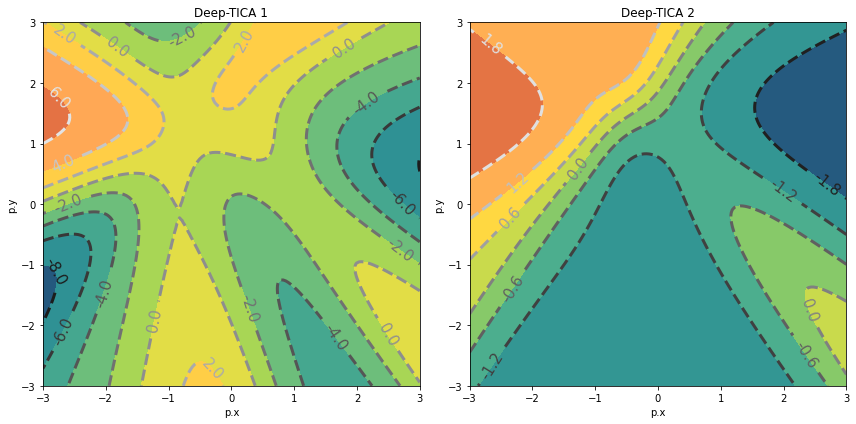

In [16]:
plot_cvs_isolines(model_cpp,points=150,n_out=2,scatter=None,axs=None)

# Time Auto-Correlation 

In [17]:
def create_time_lagged_dataset_cpp(input_file):

    #-- remove old files --#
    execute("rm w_lag.txt w_t.txt x_lag.txt x_t.txt",folder=".", print_result=False)

    #-- run create_time_lagged_dataset.exe --#
    execute("./create_time_lagged_dataset.exe "+input_file,folder=".", print_result=False)

    #--load data with pandas, much faster than numpy --#
    cpp_xt = torch.Tensor(pandas.read_csv("x_t.txt",delimiter="\t",dtype=float,header=None).to_numpy())
    cpp_xlag = torch.Tensor(pandas.read_csv("x_lag.txt",delimiter="\t",dtype=float,header=None).to_numpy())
    cpp_wt = torch.Tensor( np.transpose( pandas.read_csv("w_t.txt",delimiter="\t",dtype=float,header=None).to_numpy() )[0] )
    cpp_wlag = torch.Tensor( np.transpose( pandas.read_csv("w_lag.txt",delimiter="\t",dtype=float,header=None).to_numpy() )[0] )

    #-- create TensorDataset for training --#
    data = cpp_xt,cpp_xlag,cpp_wt,cpp_wlag
    dataset = torch.utils.data.TensorDataset(*data)

    return dataset

In [18]:
#-- My Autocorrelation --#
def my_autocorrelation_python(x,lag,weight=None,time=None):
   
    N = len(x)
    if weight is None:
        weight = np.ones(N)
    if time is None:
        time = np.arange(0,N)

    data = create_time_lagged_dataset(x, t = time, lag_time = lag, logweights = np.log(weight))
    x_t,x_lag,w_t,w_lag = np.array(data[:][0]),np.array(data[:][1]),np.array(data[:][2]),np.array(data[:][3])
    Nw = np.sum(w_t)
    mean = np.average(x_t,weights=w_t)
    variance = np.cov(x_t,aweights=w_t)
    autocorr = np.sum( np.multiply( np.multiply( (x_t-mean), (x_lag-mean) ), w_lag ) ) / (Nw*variance)

    return autocorr

#-- index tells me which is the descriptor to analyze --#
def my_autocorrelation_cpp(inputFile,lag,index,weight=True):
   
    execute("sed -i 's/lag.*/lag = "+str(lag)+"/g' "+inputFile,folder=".", print_result=False)

    if not weight:
        execute("sed -i 's/if_weights.*/if_weights = 0/g' "+inputFile,folder=".", print_result=False)

    #-- ricordo che i weights vengono moltiplicati per beta dentro la funzione cpp --#
    data = create_time_lagged_dataset_cpp(inputFile)
    x_t,x_lag,w_t,w_lag = np.array(data[:][0]).T[index],np.array(data[:][1]).T[index],np.array(data[:][2]),np.array(data[:][3])
    Nw = np.sum(w_t)
    mean = np.average(x_t,weights=w_t)
    variance = np.cov(x_t,aweights=w_t)
    autocorr = np.sum( np.multiply( np.multiply( (x_t-mean), (x_lag-mean) ), w_lag ) ) / (Nw*variance)

    return autocorr

In [19]:
##-- p.x statistics --#
x = load_dataframe(path).filter(regex="^p.x").to_numpy()
N = len(x)
x = x.reshape(N)
weight= np.exp(np.transpose( load_dataframe(path).filter(regex="^opes.bias$").to_numpy() )[0]/temp)

average = np.average(x,weights=weight)
variance = np.cov(x,aweights=weight)
print("average: ",average, ", variance: ",variance)

average:  -0.5607202403805012 , variance:  0.0063552821342113255


# Time autocorrelation python and Cpp and Pandas Autocorr 
## no weights

In [20]:
%%time
x = np.transpose(load_dataframe(path).filter(regex="^p.x").to_numpy()[:])[0]
time = np.transpose(load_dataframe(path).filter(regex="^time").to_numpy()[:])[0]
weight= np.exp(np.transpose( load_dataframe(path).filter(regex="^opes.bias$").to_numpy()[:] )[0]/temp)
autocorr = np.empty(0)
#it works
weight = None
for k in range(50):
    res = my_autocorrelation_python(x,lag=k,weight=weight,time=time)
    autocorr = np.append(autocorr,res)

CPU times: user 23.7 s, sys: 0 ns, total: 23.7 s
Wall time: 23.7 s


In [21]:
%%time
autocorr_cpp = np.empty(0)
for k in range(50):
    res = my_autocorrelation_cpp("input.dat",lag=k,index=0,weight=False)
    autocorr_cpp = np.append(autocorr_cpp,res)

CPU times: user 305 ms, sys: 9.64 s, total: 9.94 s
Wall time: 20.7 s


In [22]:
%%time
x = load_dataframe(path).filter(regex="^p.x")
autocorr_pd = np.empty(0)
#it works
weight = None
for k in range(50):
    res = x["p.x"].autocorr(k)
    autocorr_pd = np.append(autocorr_pd,res)

CPU times: user 22.2 ms, sys: 4.64 ms, total: 26.9 ms
Wall time: 25.3 ms


## plot

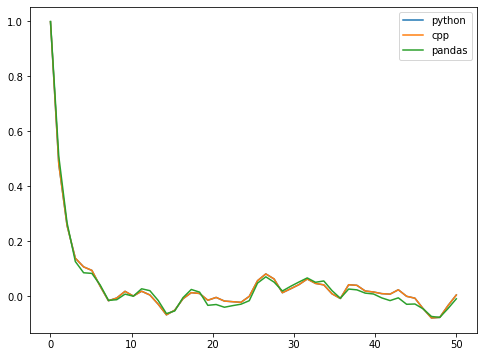

In [23]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.linspace(0,50,50),autocorr,label="python")
ax.plot(np.linspace(0,50,50),autocorr_cpp,label="cpp")
ax.plot(np.linspace(0,50,50),autocorr_pd,label="pandas")
ax.legend()

## with weights

In [24]:
%%time
x = np.transpose(load_dataframe(path).filter(regex="^p.x").to_numpy()[:])[0]
time = np.transpose(load_dataframe(path).filter(regex="^time").to_numpy()[:])[0]
weight= np.exp(np.transpose( load_dataframe(path).filter(regex="^opes.bias$").to_numpy()[:] )[0]/temp)
autocorr = np.empty(0)
for k in range(50):
    res = my_autocorrelation_python(x,lag=k,weight=weight,time=time)
    autocorr = np.append(autocorr,res)

CPU times: user 1min 7s, sys: 28.6 ms, total: 1min 7s
Wall time: 1min 7s


In [25]:
%%time
autocorr_cpp = np.empty(0)
for k in range(50):
    res = my_autocorrelation_cpp("input.dat",lag=k,index=0,weight=True)
    autocorr_cpp = np.append(autocorr_cpp,res)

CPU times: user 355 ms, sys: 6.83 s, total: 7.18 s
Wall time: 15.1 s


# Plot

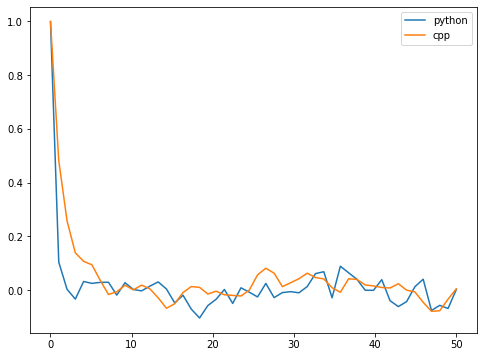

In [26]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.linspace(0,50,50),autocorr,label="python")
ax.plot(np.linspace(0,50,50),autocorr_cpp,label="cpp")
ax.legend()